### ライブラリのimport

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline
from preprocessing.initial_preprocessing import initial_preprocessing
from preprocessing.drop_emergency_suspicious_height_weight import drop_emergency_suspicious_height_weight
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category
from preprocessing.remove_duplicate_ctdi import remove_duplicate_ctdi
from permutation_feature_importance.PermutationFeatureImportance import PermutationFeatureImportance 

/tmp/ipykernel_298/855513869.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## 解析用の元データを読み込み

In [2]:
df = pd.read_excel('train_data.xlsx')

## データを前処理
* カラム名の変更
* 複数回スキャンについては,Mean CTDIvolが最大のみ残す
* 救急科などの怪しい身長と体重のデータを削除する

In [3]:
initial_preprocessing(df)
df = remove_duplicate_ctdi(df)
df.reset_index(drop=True, inplace=True)
# df_allで後で、身長体重を代入する分を分けられるようにしておく
df_all = df
df = drop_emergency_suspicious_height_weight(df)

正常に処理が行われました。


### 身長・体重の最終確認: この部分は自分で確認しないと危険

In [4]:
df['height_cm'].sort_values()

1200    101.0
97      101.0
2241    101.0
2362    101.0
1011    101.0
        ...  
8610    190.9
7978    190.9
790     193.0
8       193.0
5567    193.0
Name: height_cm, Length: 8958, dtype: float64

In [5]:
index = df['height_cm'].sort_values(ascending=True)[:30].index.to_list()

In [6]:
df[['scanning length', 'height_cm', 'weight_kg', 'id', 'study_date', 'target region', 'Mean CTDIvol']].loc[index]

,scanning length,height_cm,weight_kg,id,study_date,target region,Mean CTDIvol
1200,796.77,101.0,39.80,75206,2021-06-18,Chest,6.70
97,626.53,101.0,39.80,75206,2021-01-14,Abdomen,12.78
2241,852.06,101.0,39.80,75206,2021-04-21,Chest,6.45
2362,621.51,101.0,39.80,75206,2021-06-02,Abdomen,17.10
1011,796.77,101.0,39.80,75206,2021-05-18,Chest,7.38
265,567.16,101.0,39.80,75206,2021-02-04,Chest,6.03
620,827.20,101.0,39.80,75206,2021-03-29,Chest,6.13
6436,506.63,117.7,76.40,9326611,2023-02-10,Bronchus,10.38
3529,531.81,117.7,76.40,9326611,2022-01-21,Bronchus,9.90
106,456.72,117.7,76.40,9326611,2021-01-15,Chest,9.14


In [7]:
# 最終的な怪しいデータに関しては直接データを確認して削除する
drop_ids = [75206, 9326611, 17049]
for ids in drop_ids:
    df = df[~(df['id'] == ids)]
df.reset_index(drop=True, inplace=True)

### 身長体重予測、線量予測、異常検知でも使用しない項目を削除する

In [8]:
unuse_cols = ['hospital_ward', 'modality', 'adult_child', 'department', 'preset_name']
df.drop(labels=unuse_cols, axis=1, inplace=True)

In [9]:
df.to_excel('preprocess_all_scan_data.xlsx')

### 新たな特徴量を作成する

* BMI(Body Mass Index)  
  $BMI = weight(kg) / height(m)^2$  
  
* BMR(Basal Metabolic Rate: 基礎代謝率): 年齢、性別、身長、体重に基づいて計算される。ハリス・ベネディクト方程式と呼ばれる  
  男性$BMR=66.47 + (13.75*weight[kg]) + (5.003*height[cm]) - (6.755*age[歳])$  
  女性$BMR=655.1 + (9.563*weight[kg]) + (1.85*height[cm]) - (4.676*age[歳])$  
  
* 体格指数(Rohrer's index) ：学童期に適するとあるので、今回は使わない  
  $Rohrer's index = weight[kg] / height[m]^3$

体格指数（BMI）: 体重（kg）を身長（m）の二乗で割ったもので、以下のように分類されます（成人向けのWHOのガイドライン）。

18.5未満: 低体重（痩せ型）: underweight    
18.5～24.9: 標準体重: normal weight   
25.0～29.9: 肥満（1度）:obesity class1  
30.0～34.9: 肥満（2度）:obesity class2  
35.0～39.9: 肥満（3度）:obesity class3    
40以上: 肥満（4度、重症）:obesity class4

In [10]:
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category

In [11]:
calculate_bmi_bmr_category(df)

In [12]:
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '頸部CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '頸部〜骨盤CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '胸部〜骨盤CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '胸部CT'))]

In [13]:
df['age_era'] = (df['age'] // 10) * 10

### 前処理が終了したデータを保存する。

In [14]:
df.to_excel('preprocessed_train_data.xlsx', index=False)

In [109]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [117]:
# デフォルト条件でlightbgmを行う
from sklearn.model_selection import KFold
import numpy as np

objective = 'mae' # 'mse'

params = {
    'objective': objective,
    'seed': 0, 
    'verbose': -1
}

test_scores = []
models = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
    X_tr = X.iloc[tr_idx]
    X_va = X.iloc[va_idx]
    y_tr = y.iloc[tr_idx]
    y_va = y.iloc[va_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
    
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(50)])
    
    models.append(model.best_iteration)
    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MSE valid: {score:.2f}')
    print('')
    
    # スコア、モデル、予測値の格納
    test_scores.append(score)

# クロスバリデーションの平均スコア
cv_score = np.mean(test_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.45092	valid's l1: 2.85449
[100]	train's l1: 2.30627	valid's l1: 2.80916
[150]	train's l1: 2.21635	valid's l1: 2.79116
[200]	train's l1: 2.15095	valid's l1: 2.77786
[250]	train's l1: 2.10168	valid's l1: 2.7676
[300]	train's l1: 2.05848	valid's l1: 2.76632
[350]	train's l1: 2.02793	valid's l1: 2.76538
Early stopping, best iteration is:
[261]	train's l1: 2.087	valid's l1: 2.76315
fold 1 MSE valid: 2.76

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.54716	valid's l1: 2.52455
[100]	train's l1: 2.38409	valid's l1: 2.46134
[150]	train's l1: 2.29346	valid's l1: 2.44628
[200]	train's l1: 2.22415	valid's l1: 2.44565
[250]	train's l1: 2.16941	valid's l1: 2.44093
[300]	train's l1: 2.1378	valid's l1: 2.44203
[350]	train's l1: 2.09923	valid's l1: 2.43684
[400]	train's l1: 2.06289	valid's l1: 2.435
[450]	train's l1: 2.03595	valid's l1: 2.43106
[500]	train's l1: 2.01615	valid's l1: 2.423

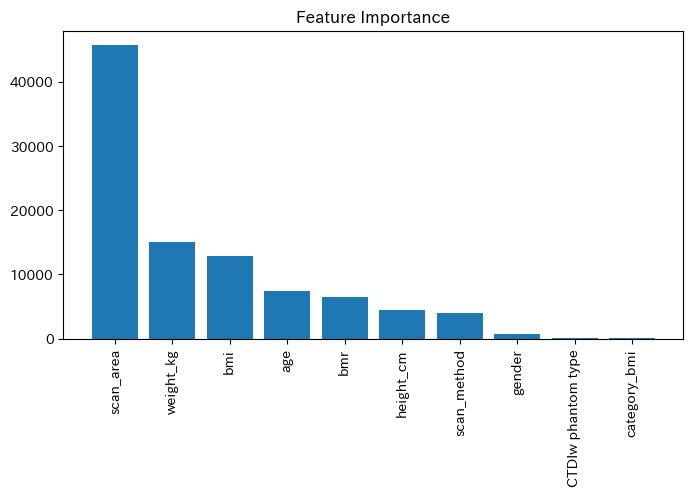

In [112]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title('Feature Importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.show()

### EDA

In [ ]:
profile= ProfileReport(df, title='preprocessing_data')
profile.to_file('preprocessing_data.html')

* データに含まれている外れ値のデータはさらに削除しても良いかも

In [2]:
import pandas as pd
df = pd.read_excel('preprocessed_train_data.xlsx')
df

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi,age_era
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,80
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1,60
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,46,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,40
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,52,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,50
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,52,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obesity class3,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,1364925420230425,"5.12 Chest - Pelvis (40sec,80sec)Routine",CE,Chest,916.19,100,450.77,700,0.99,80,...,48,M,166.0,71.0,胸部〜骨盤CT,造影,25.77,1548.98,obesity class1,40
8932,1365245120230426,6.2 Abdomen-Pelvis Routine,Plain,Abdomen and Pelvis,626.27,100,414.06,720,0.99,80,...,36,M,174.0,73.4,腹部〜骨盤CT,造影,24.24,1703.06,normal weight,30
8933,1365256720230426,"5.36 GSIX Aorta CTA prep (CTA, +20s) Delay onl...",CTA,Chest,5.00,100,100.00,100,1.00,5,...,44,M,171.0,65.0,左上肢ｼｬﾝﾄCT,Dual Energy,22.23,1518.51,normal weight,40
8934,1365967020230428,"6.4 HCC 3Phase (40sec,70sec,180sec) Routine",CE,Abdomen,551.66,100,354.37,720,0.99,80,...,50,M,176.5,56.2,腹部〜骨盤CT,造影,18.04,1384.50,under weight,50


In [18]:
df.sort_values(by=['weight_kg'], ascending=False)[:12][['accession', 'scan protocol', 'scan series', 'Mean CTDIvol', 'bmi', 'weight_kg']]

,accession,scan protocol,scan series,Mean CTDIvol,bmi,weight_kg
4329,1249030520220420,5.16 QQ Full FOV Chest - Pelvis 80cm,Plain,75.25,53.15,172.2
6831,1355672120230329,5.28 GSIX Chest-Pelvis CEonly,CE Dual Energy,41.43,50.72,151.8
6933,1361384220230416,5.28 GSIX Chest-Pelvis CEonly,CE Dual Energy,41.43,50.72,151.8
8869,1351460220230315,5.7 QQ Full FOV Chest - Pelvis 80cm,CE,34.94,50.72,151.8
8828,1346485720230228,6.2 Abdomen-Pelvis Routine,CE,61.33,50.72,151.8
8849,1348835920230307,5.7 QQ Full FOV Chest - Pelvis 80cm,Plain,106.63,50.72,151.8
7663,1229782420220221,"5.9 Chest - Pelvis Dynamic (40sec,70sec,180sec...",Plain,60.64,41.93,146.0
3471,1217692720220118,5.1 QQ Chest Routine,Plain,21.72,44.94,145.6
893,1145002420210504,5.1 QQ Chest Routine,NaN,17.17,37.33,125.0
8,1103770520210104,5.1 QQ Chest Routine,NaN,16.31,33.02,123.0


In [19]:
# 外れ値として取り扱うデータを追加
drop_accession_list = [1249030520220420, 1351460220230315, 1346485720230228, 1348835920230307,
                       1229782420220221]
for accession in drop_accession_list:
    df = df[~(df['accession'] == accession)]
df.reset_index(drop=True, inplace=True)

In [20]:
len(df)

8931

In [21]:
df.to_excel('preprocessed_train_data.xlsx', index=False)